<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/EVA2/Assignment1/Neural_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting google drive with Colab notebook to download word embedding and actual imdb rattings zip files.**

In [1]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ../content/drive/


**Install unzip in runtime to unzip zip files**

In [2]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


**Unzip Imdb review zip file.**

In [3]:
!unzip drive/My\ Drive/datasets/aclImdb.zip

Streaming output truncated to the last 5000 lines.
  inflating: aclImdb/train/pos/7755_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7755_9.txt  
  inflating: aclImdb/train/pos/7756_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7756_10.txt  
  inflating: aclImdb/train/pos/7757_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7757_9.txt  
  inflating: aclImdb/train/pos/7758_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7758_7.txt  
  inflating: aclImdb/train/pos/7759_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7759_10.txt  
  inflating: aclImdb/train/pos/775_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._775_7.txt  
  inflating: aclImdb/train/pos/7760_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7760_10.txt  
  inflating: aclImdb/train/pos/7761_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7761_10.txt  
  inflating: aclImdb/train/pos/7762_8.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7762_8.txt  
  inflating: aclImdb/train/pos/7763_8.txt  
  inflat

**Unzip word embedding from https://nlp.stanford.edu/projects/glove/ and save it to a directory called glove**

In [4]:
!unzip drive/My\ Drive/datasets/glove.6B.zip -d glove

Archive:  drive/My Drive/datasets/glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


## Process Imdb reviews

In [0]:
import os

'''
- All reviews are present in aclImdb directory.
- Training dataset present in aclImdb/train and test dataset present in aclImdb/test
- All positive reviews present inside aclImdb/train/pos and all negative reviews are present inside aclImdb/train/neg.
Review files are text file.
'''

imdb_dir = 'aclImdb' # Directory where review present
train_dir = os.path.join(imdb_dir, 'train') # Append train directory into the path 
labels = []
texts = []

# Inside the training directory loop over both pos and neg directories
# For each append the text to texts array
# For positive review add the label as 1 and for negative set the label as 0
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

**Print total samples in our training data set**

In [6]:
# Total number of samples
total_samples = len(texts)
print('Total number of samples: ', total_samples)

Total number of samples:  25000


**Tokenize the datasets using Keras preprocessing API**

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # No of words to take from a review
training_samples = round(total_samples * 0.75) # no training sample
validation_samples = (total_samples - training_samples) # no of validation sample
max_words = 10000 # Top 1000o words from the the total words to use for Tokenizing
print(training_samples, validation_samples)

# Tokenize the words words using keras preprocessing library
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

Using TensorFlow backend.


18750 6250


**Create training and validation samples from the dataset**

In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Create train and test dataset from the total records
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


**Load word embeddings from  the file.**

In [9]:
# Directory where unzipped word embeddings are present
glove_dir = 'glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

# Loop through each line of the word embeding and set the word and it's co-efficient into the  embeddings_index
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


**Create word embedding matrix from the downloaded embedding and the words from the review.**

In [0]:
# Embedding dimensions, this is a hyper paramter for the model
embedding_dim = 100

# Create a numpy array of dimension (max_words, embedding_dim) and assign default value as 0
embedding_matrix = np.zeros((max_words, embedding_dim))

# Loop over each word from the word_index created from the Imdb review 
# Find cofficient of each words till max_words count and assign the co-efficient into the embedding matrix
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

**Deep learning Model.**

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


**Set the word embedding weights in the first layer of the model and set trainable as False, since we want to use the weights from word embeddings in our model and it shouldn't train the first layer again.**

In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

**Compile and run the model.**

In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 4s 198us/step - loss: 0.6471 - acc: 0.6380 - val_loss: 0.5569 - val_acc: 0.7229
Epoch 2/10
18750/18750 [==============================] - 3s 173us/step - loss: 0.5299 - acc: 0.7373 - val_loss: 0.5397 - val_acc: 0.7293
Epoch 3/10
18750/18750 [==============================] - 3s 175us/step - loss: 0.4700 - acc: 0.7785 - val_loss: 0.5547 - val_acc: 0.7256
Epoch 4/10
18750/18750 [==============================] - 3s 174us/step - loss: 0.4288 - acc: 0.8035 - val_loss: 0.5907 - val_acc: 0.7088
Epoch 5/10
18750/18750 [==============================] - 3s 174us/step - loss: 0.4219 - acc: 0.8059 - val_loss: 0.6241 - val_acc: 0.7069
Epoch 6/10
18750/18750 [==============================] - 3s 173us/step - loss: 0.4888 - acc: 0.7810 - val_loss: 0.6050 - val_acc: 0.7253
Epoch 7/10
18750/18750 [=

Plot for train vs validation accuracy and train vs validation loss.

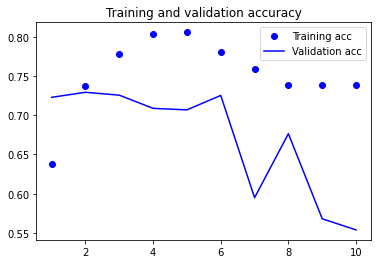

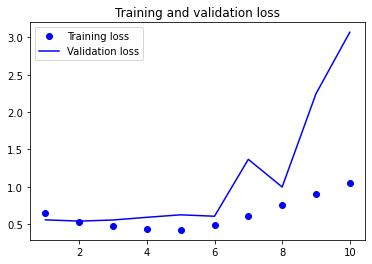

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Load the test data to validate the accuracy of the model.**

In [0]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

# Loop over both positive and negative reviews from test directory and create labels and texts array
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

# Tokenize test data using Keras tokenizer
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

**Load the saved model and validate the model with test data.**

In [16]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 43us/step


[3.117371182357592, 0.5488]